In [19]:
# 다중 분류, 숫자 이미지의 짝수/홀수 판별, CNN, GPU, Colab

In [20]:
# %autosave 0
import warnings
warnings.filterwarnings(action='ignore')

import os 
import random
import sys
import time
from time import localtime, strftime

import pandas as pd
import numpy as np
import tensorflow as tf
import seaborn as sb
import cv2

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

import matplotlib.pyplot as plt
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
# plt.rcParams["figure.figsize"] = (10, 4) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ----------------------------------------------------------------
# OS
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
# ----------------------------------------------------------------

In [21]:
# 최초에만 다운로드 발생
(x_train, y_train), (x_test, y_test)  = mnist.load_data()
width=28
height=28

x_train = x_train.reshape(60000, 28, 28, 1).astype('float32') / 255.0
print('x_train:', x_train.shape)

x_test = x_test.reshape(10000, 28, 28, 1).astype('float32') / 255.0
print('x_test:', x_test.shape)

x_train: (60000, 28, 28, 1)
x_test: (10000, 28, 28, 1)


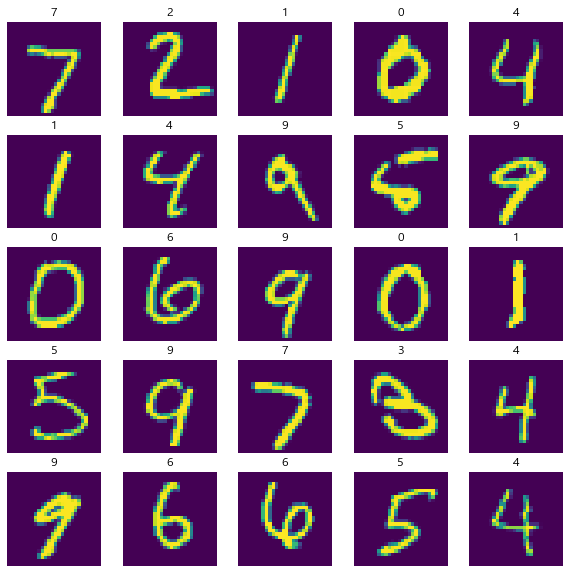

In [22]:
# 데이터 확인
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10) # 이미지 사이즈 설정

f, axarr = plt.subplots(plt_row, plt_col) # 5행 5열 배열 plot 구조 생성

for i in range(plt_row * plt_col): # 25: 0 ~ 24
    sub_plt = axarr[i // plt_row, i % plt_col] # 행열 위치 설정
    sub_plt.axis('off') # 축 label 출력 생략
    
    # 1차원 배열 -> 2차원 배열로 변경
    # 2차원 이미지로 출력하기위해 784 -> 28행 28열로 변경
    sub_plt.imshow(x_test[i].reshape(width, height))  
    
    sub_plt_title = y_test[i] # 0 ~ 9 숫자
        
    sub_plt.set_title(sub_plt_title) # 이미지 제목

plt.show()

In [23]:
# 반복 실행시 에러 발생, 변경 부분 확인
print(y_test[0:3])
y_train = to_categorical(y_train, 10)  # One-Hot encoding
y_test = to_categorical(y_test, 10)
print(y_test.shape)
print(y_test[0:3])

[7 2 1]
(10000, 10)
[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [24]:
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

# 데이터 준비
(x_train, y_train), (x_test, y_test) = mnist.load_data()
width=28
height=28

# 기존 데이터에 색상 정보 추가
# 데이터가 0 부터 255로 구성되어 있음으로 255로 나누어서 정규화
# 28 x 28 필셀의 흑백이미지(1) 60000장 구조 생성
x_train = x_train.reshape(60000, 28, 28, 1).astype('float32') / 255.0
# 28 x 28 필셀의 흑백이미지(1) 10000장 구조 생성
x_test = x_test.reshape(10000, 28, 28, 1).astype('float32') / 255.0

y_train = to_categorical(y_train, 10)  # One-Hot encoding
y_test = to_categorical(y_test, 10)

model = Sequential()
model.add(Conv2D(32, kernel_size = (3, 3), padding='same',
                 input_shape = (28, 28, 1), activation='relu'))
model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
# 4개중에 최대값 1개만 다음 레이어로 전달, 슬라이딩이 작동되어 파라미터수가 50%로 감소함 
model.add(MaxPooling2D(pool_size=(2, 2))) 

model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) # 25%만 사용
model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Flatten()) # 3차원 텐서의 형태를 1차원 열방향으로 변경
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25)) # node 25% 사용하지 않음.

model.add(Dense(10, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', 
                                metrics=['accuracy'])
model.summary()

es = EarlyStopping(monitor='loss', patience=1, restore_best_weights=True)
start = time.time()
# 장비 속도가 느려 3번만 진행
hist = model.fit(x_train, y_train, validation_split = 0.2, 
                 shuffle=True, epochs=3, 
                 batch_size=30, callbacks=[es])
end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start))
# cpu i5 2320 : 375s(Meet 실행시: 607), i5 8500: 169s
# Ryzen 5 5600: 115s
# RTX 3090: 19s, Colab gpu: 83~140s

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 16)        2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
dropout (Dropout)            (None, 7, 7, 16)         

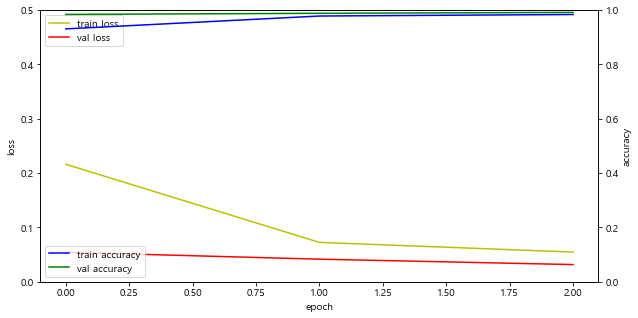

In [25]:
fig, loss_ax = plt.subplots()
# plt.figure(figsize=(6,4)) # ERROR
fig.set_size_inches(10, 5)  # 챠트 크기 설정

acc_ax = loss_ax.twinx()  # 오른쪽 y 출 설정

# 왼쪽 y 축 설정
loss_ax.plot(hist.history['loss'], 'y', label='train loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val loss')
loss_ax.set_ylim([0.0, 0.5]) # 값을 반영하여 변경

# 오른쪽 y 축 설정
acc_ax.plot(hist.history['accuracy'], 'b', label='train accuracy')
acc_ax.plot(hist.history['val_accuracy'], 'g', label='val accuracy')
acc_ax.set_ylim([0.0, 1.0])

# 축 레이블 설정
loss_ax.set_xlabel('epoch' )  # 학습 횟수
loss_ax.set_ylabel('loss')    # 왼쪽 y 축 레이블, 오차
acc_ax.set_ylabel('accuracy') # 오른쪽 y 축 레이블,정확도

loss_ax.legend(loc='upper left') # 왼쪽 y 축 오차 레이블 위치
acc_ax.legend(loc='lower left')  # 오른쪽 y 축 정확도 레이블 위치

plt.show()

In [26]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=50, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.028654787689447403 /정확도: 99.01000261306763 %


In [27]:
model.save('./Mnist3_cnn.h5')

model = load_model('./Mnist3_cnn.h5')

yp = model.predict(x_test, batch_size=32)
print(yp[0:10])

[[1.7023222e-09 4.7115254e-06 3.7639379e-07 2.2837137e-06 4.8726996e-09
  1.5674072e-08 2.8246376e-11 9.9999070e-01 1.9334012e-08 1.8712238e-06]
 [1.4809113e-07 7.2841763e-06 9.9999249e-01 2.6237352e-09 1.7120982e-08
  3.5363585e-12 3.8022250e-08 4.0898529e-10 6.1389002e-08 5.7769206e-10]
 [1.3342262e-07 9.9978179e-01 3.6050931e-06 6.0404676e-07 2.5036816e-05
  2.6717003e-05 7.5069089e-05 5.9869366e-05 1.9953934e-05 7.4013983e-06]
 [9.9956793e-01 4.6344693e-09 4.4593812e-06 4.1276962e-08 5.8930109e-06
  2.5341512e-06 3.7432226e-04 7.7215752e-08 2.1012779e-06 4.2809672e-05]
 [2.1233897e-07 2.6557680e-06 3.9727843e-07 7.3865451e-08 9.9843520e-01
  5.1623772e-08 5.6695484e-07 6.6448359e-07 1.5099005e-05 1.5450135e-03]
 [7.8332913e-09 9.9998045e-01 3.4905122e-07 4.6955995e-09 2.3010944e-06
  9.3362053e-07 5.5532823e-06 7.4587460e-06 2.2738889e-06 6.1552089e-07]
 [3.7871672e-08 4.4193029e-04 1.7352611e-06 1.5884346e-07 9.9813747e-01
  7.2982571e-06 7.1793684e-06 1.7119834e-05 3.4242051e-04 

In [28]:
cnt = 0
for i in range(10): # 0 ~ 9
    title = str(np.argmax(y_test[i])) + ' / ' + str(np.argmax(yp[i]))
    print(title)

7 / 7
2 / 2
1 / 1
0 / 0
4 / 4
1 / 1
4 / 4
9 / 9
5 / 5
9 / 9


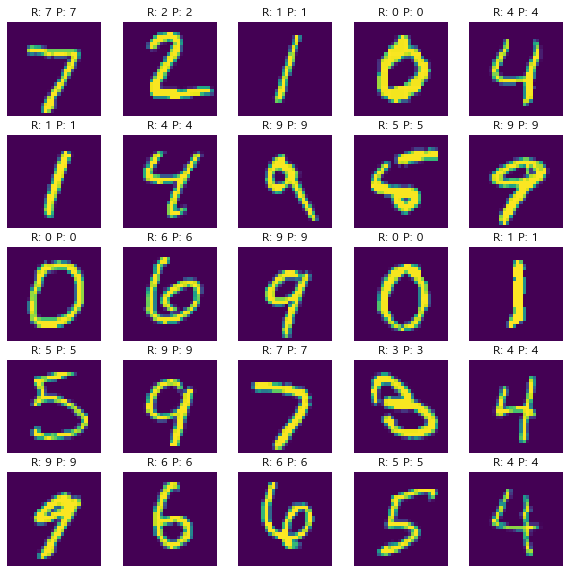

In [29]:
# 모델 사용하기
yhat_test = model.predict(x_test, batch_size=32)

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

cnt = 0
i = 0

while cnt < (plt_row*plt_col):
    sub_plt = axarr[cnt//plt_row, cnt%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt_title = 'R: ' + str(np.argmax(y_test[i])) + ' P: ' + str(np.argmax(yhat_test[i]))
    sub_plt.set_title(sub_plt_title)

    i += 1    
    cnt += 1

plt.show()

## evaluation loss and_metrics ##
손실값: 0.028654778376221657  정확도: 99.01000261306763


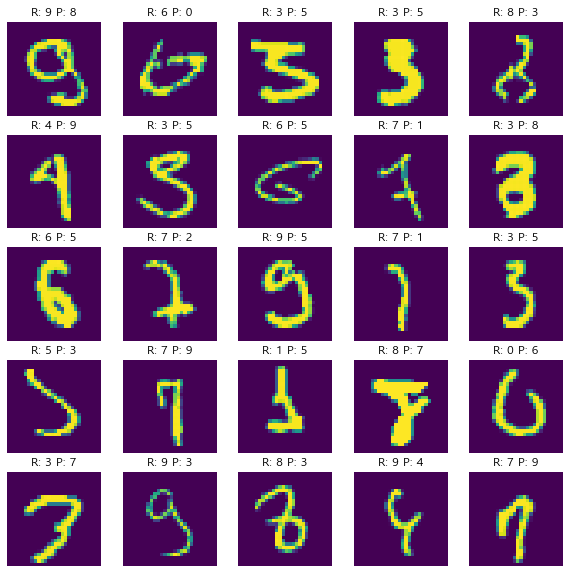

In [30]:
# 오답 이미지만 출력
loss_and_metrics = model.evaluate(x_test, y_test, batch_size=32, verbose=0)
print('## evaluation loss and_metrics ##')
print('손실값:',loss_and_metrics[0], ' 정확도:', (loss_and_metrics[1] * 100))

yhat_test = model.predict(x_test, batch_size=32)

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

cnt = 0
i = 0

while cnt < (plt_row*plt_col):
    
    if np.argmax(y_test[i]) == np.argmax(yhat_test[i]):
        i += 1
        continue # 정답일 경우 출력 안함.
    
    sub_plt = axarr[cnt//plt_row, cnt%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt_title = 'R: ' + str(np.argmax(y_test[i])) + ' P: ' + str(np.argmax(yhat_test[i]))
    sub_plt.set_title(sub_plt_title)

    i += 1    
    cnt += 1

plt.show()